## Titanic Machine Learning Exercise

The purpose of this exercise is to practice machine learning techniques in Python. The data and inspiration is from Kaggle's [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview).

"In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)."

The values in the second column ("Survived") can be used to determine whether each passenger survived or not:
* if it's a "1", the passenger survived.
* if it's a "0", the passenger died.

Variable Definition	Key: 

* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex	
* Age	Age in years	
* sibsp	# of siblings / spouses aboard the Titanic	
* parch	# of parents / children aboard the Titanic	
* ticket	Ticket number	
* fare	Passenger fare	
* cabin	Cabin number	
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Other variable notes:
    
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Pushing notebook to GitHub: https://towardsdatascience.com/how-to-use-git-github-with-jupyter-notebook-7144d6577b44

> It is a simple binary classification problem, and all you need to do is predict if a particular passenger survived. The best thing about this dataset is that all the pre-processing is done for you. You have a nice, clean dataset to train your machine learning model.
**Since this is a classification problem, you can choose to use algorithms like logistic regression, decision trees, and random forests to build the predictive model. You can also choose gradient boosting models like an XGBoost classifier for this beginner-level machine learning project to get better results.**

From https://www.kdnuggets.com/2021/09/20-machine-learning-projects-hired.html

### Reading in the Data

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import poisson
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [241]:
# Read in the data to train the model
train=pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [300]:
train.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [299]:
# Read in the test data
test=pd.read_csv("test.csv")

In [244]:
# Create a "combined" data to edit both
combine=[train,test]

The Name column is only valuable to us if we extract the title (Mr., Mrs., Miss to tell us if someone is married or unmarried). We can see that the title comes after the last name.

In [245]:
for dataset in combine:
    dataset['Name']=dataset["Name"].apply(lambda x: x.split(","))
    dataset["Name"]=[x[1] for x in dataset["Name"]]
    dataset['Name']=dataset["Name"].apply(lambda x: x.split())
    dataset["title"]=[x[0] for x in dataset["Name"]]

In [246]:
train.title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the',
       'Jonkheer.'], dtype=object)

In [247]:
names=['Mr.', 'Mrs.', 'Miss.', 'Master.']
train['title']=[x if x in names else "Other" for x in train["title"]]

In [248]:
train.title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Other'], dtype=object)

We can see that there are a few different title in our data set. I've created a new data column called "title".

In [249]:
# Overview of data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


By looking at these basic summary statistics and the first few rows of our data, we can see that we have 891 observations. 1 means the passenger survived, and 0 means that the passenger died. We can see that the average age of our passengers was around 30 years old. 

I am going to drop a few columns that I do not think will be relevant to our analysis.
* Passenger ID - this can be dropped since it just numbers our rows.
* Name - we have created a title column, so we no longer need the name column.
* Ticket - there seems to be no pattern in the ticket numbers that would help us predict survival. 
* Cabin - most of these values are missing; therefore, it will not be overly predictive in our model.

In [250]:
# Drop unnecessary columns
train=train.drop(["PassengerId", "Name", "Ticket", "Cabin"],axis=1)
test=test.drop(["PassengerId", "Name", "Ticket", "Cabin"],axis=1)

combine = [train, test]

Lastly, I am going to change the Sex variable to 1 for female and 0 for male.

In [251]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

Let's do a brief exploratory data analysis before we fit our machine learning models.

### Exploratory Data Analysis

In [252]:
print("Are there null values?", train.isnull().values.any())
print(train.isnull().sum())

Are there null values? True
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
title         0
dtype: int64


Here, we can see there are null values in Age and Embarked. I need to fill in the missing values for age. I can either remove those rows, fill in the missing values with 0, or fill in the missing values with the mean/mean of the row. I also could consider alternative techniques. For now, I am going to fill in those missing values with the median.

It was not effective replacing the missing values with the median. I am using a technique I found from this [Kaggle notebook](https://www.kaggle.com/startupsci/titanic-data-science-solutions) that generates random ages based on a passengers gender and class.

In [253]:
# Fill in empty values for age
# empty matrix 
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

In [254]:
# Fill in empty values for Embarked
train.Embarked.mode()

# S is the most common place to embark from, so we will fill our missing values with "S"

0    S
dtype: object

In [255]:
# Fill in empty values for Embarked
train['Embarked'] = train['Embarked'].fillna("S")

In [289]:
print("Are there null values for TEST data?", test.isnull().values.any())
print(test.isnull().sum())

Are there null values for TEST data? False
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
title       0
dtype: int64


In [257]:
# Fill in missing value for Fare in test data
test['Fare'].fillna((test['Fare'].median()), inplace=True)

#### EDA Charts

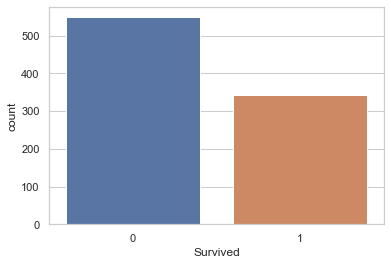

In [258]:
sns.countplot(data=train, x="Survived")
plt.show()

In [259]:
count_dead = len(train[train['Survived']==0])
count_survived = len(train[train['Survived']==1])
pct_dead = count_dead/len(train['Survived'])
print("percentage of dead is", pct_dead*100)
pct_survived = count_survived/len(train['Survived'])
print("percentage of survived", pct_survived*100)

percentage of dead is 61.61616161616161
percentage of survived 38.38383838383838


We can see that our data is imbalanced, as there are more people who died in the Titanic than survived.

In [260]:
train.groupby("Survived").mean()

,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,,,,,,
0,2.531876,0.147541,29.706740,0.553734,0.329690,22.117887
1,1.950292,0.681287,28.055556,0.473684,0.464912,48.395408


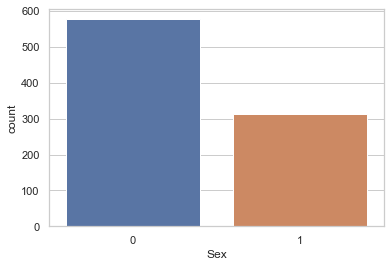

In [261]:
sns.countplot(data=train, x="Sex")
plt.show()

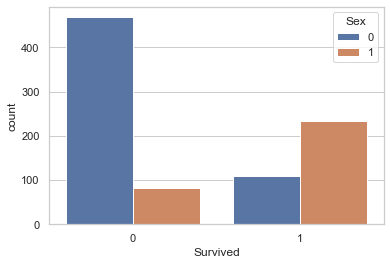

In [262]:
sns.countplot(data=train, x="Survived", hue="Sex")
plt.show()

In [263]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
1,1,0.742038
0,0,0.188908


We can see more woman were more likely to survive than men.

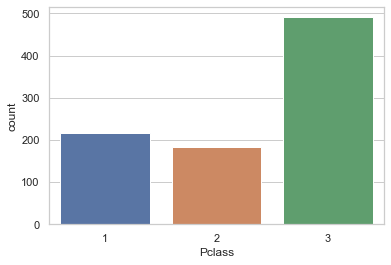

In [264]:
sns.countplot(data=train, x="Pclass")
plt.show()

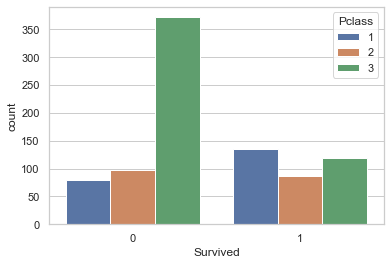

In [265]:
sns.countplot(data=train, x="Survived", hue="Pclass")
plt.show()

In [266]:
train[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


We can see that the first class was more likely to survive than the other classes.

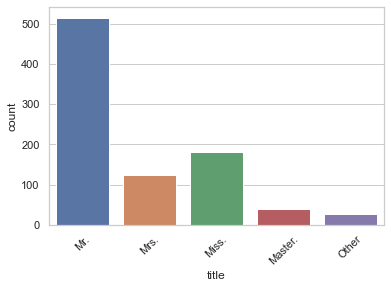

In [267]:
sns.countplot(data=train, x="title")
plt.xticks(rotation=45)
plt.show()

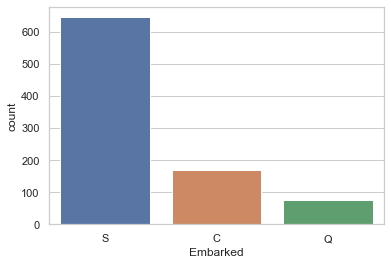

In [268]:
sns.countplot(data=train, x="Embarked")
plt.show()

In [269]:
train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


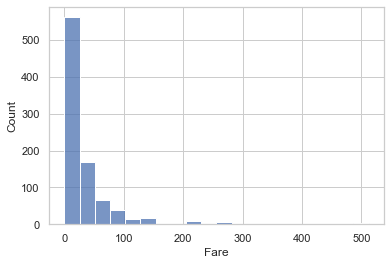

In [270]:
sns.histplot(data=train, x="Fare", bins=20)
plt.show()

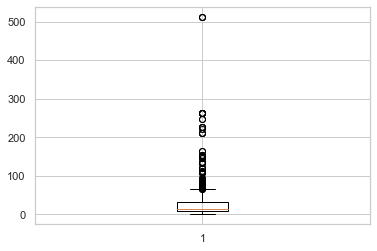

In [271]:
plt.boxplot(train['Fare'])
plt.show()

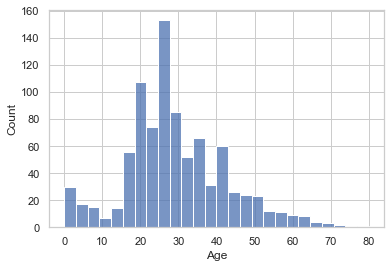

In [272]:
sns.histplot(data=train, x="Age")
plt.show()

In [273]:
mn=train.Age.min()
mx=train.Age.max()
x=np.linspace(mn,mx,100)
mean=train.Age.mean()
std=train.Age.std()
z=norm.pdf(x,mean,std)

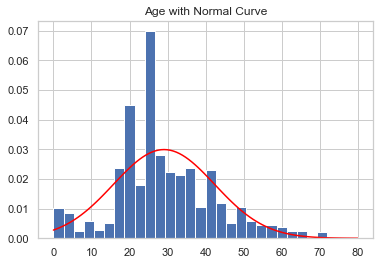

In [274]:
plt.hist(train['Age'], density=True, bins=30)
plt.plot(x,z,color="red")
plt.title("Age with Normal Curve")
plt.show()

What if we look at survival rate by age?

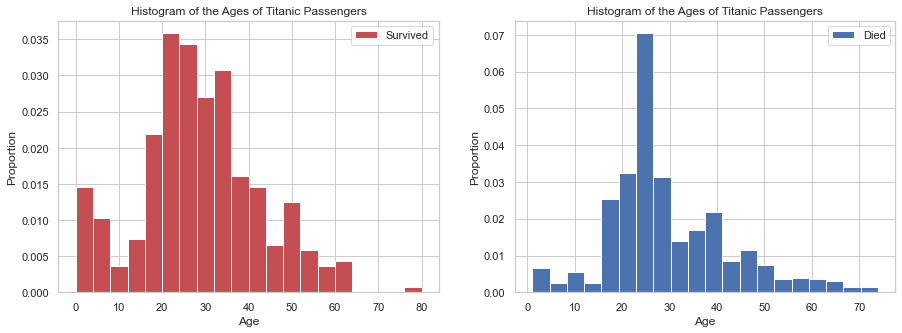

In [275]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

survived=train[train["Survived"]==1]
died=train[train["Survived"]==0]

ax[0].hist(survived['Age'], density=True, color='r', label='Survived', bins=20)
ax[1].hist(died['Age'], density=True, color='b', label='Died', bins=20)
ax[0].set(xlabel="Age", ylabel="Proportion", title="Histogram of the Ages of Titanic Passengers")
ax[1].set(xlabel="Age", ylabel="Proportion", title="Histogram of the Ages of Titanic Passengers")
ax[0].legend()
ax[1].legend()
plt.show()

We can see that the distributions are right skewed, especially for those who survived. Young people were more likely to survive the Titanic.

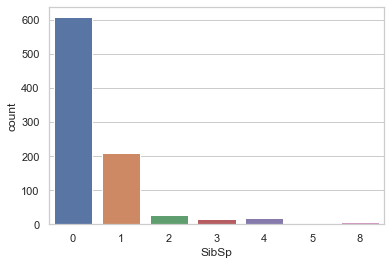

In [276]:
sns.countplot(data=train, x="SibSp")
plt.show()

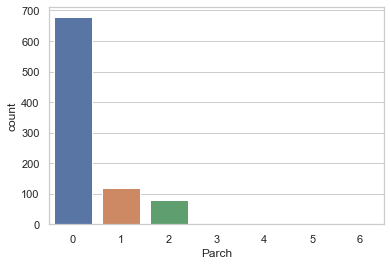

In [277]:
sns.countplot(data=train, x="Parch")
plt.show()

### Machine Learning Models

#### Process from Kaggle

To continue, I am going to change our remaining categorical variable to numeric values to include them in our model.

In [278]:
# Title
titles = {"Mr.": 1, "Miss.": 2, "Mrs.": 3, "Master.": 4, "Other": 5}

for dataset in combine:
    dataset['title'] = dataset['title'].map(titles)
    dataset['title'] = dataset['title'].fillna(0)

In [279]:
# Embarked
places = {"S": 0, "C": 1, "Q": 2}

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map(places)

In [301]:
# Fit variables
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 11))

Information from: https://realpython.com/logistic-regression-python/

#### sklearn method

In [311]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [310]:
# Train model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

/Users/elizabethtrahadias/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: could not convert string to float: 'Kelly, Mr. James'

In [303]:
print("Train accuracy:", logreg.score(X_train, Y_train))

Train accuracy: 0.819304152637486


#### statsmodel example

In [292]:
# Implementing the model with statsmodels
import statsmodels.api as sm

logit_model=sm.Logit(Y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.429085
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.356     
Dependent Variable: Survived         AIC:              780.6297  
Date:               2021-12-21 16:17 BIC:              818.9684  
No. Observations:   891              Log-Likelihood:   -382.31   
Df Model:           7                LL-Null:          -593.33   
Df Residuals:       883              LLR p-value:      4.4945e-87
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Pclass        -0.7272    0.0804  -9.0400  0.0000  -0.8849  -0.5695
Sex            2.2122    0.2075  10.6587  0.0000   1.8054   2.

**Standardizing: https://realpython.com/logistic-regression-python/**

It’s a good practice to standardize the input data that you use for logistic regression, although in many cases it’s not necessary. Standardization might improve the performance of your algorithm. It helps if you need to compare and interpret the weights. It’s important when you apply penalization because the algorithm is actually penalizing against the large values of the weights.

You can standardize your inputs by creating an instance of StandardScaler and calling .fit_transform() on it:

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
.fit_transform() fits the instance of StandardScaler to the array passed as the argument, transforms this array, and returns the new, standardized array. Now, x_train is a standardized input array.

#### Process from Towards Data Science

To begin, I am going to fit a logistic regression model. I am using code modified from [Towards Data Science](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8).

**Logistic Regression Assumptions**
* Binary logistic regression requires the dependent variable to be binary.
* For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
* Only the meaningful variables should be included.
* The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
* The independent variables are linearly related to the log odds.
* Logistic regression requires quite large sample sizes.

In [282]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,title
0,0,3,0,22,1,0,7.2500,0,1
1,1,1,1,38,1,0,71.2833,1,3
2,1,3,1,26,0,0,7.9250,0,2
3,1,1,1,35,1,0,53.1000,0,3
4,0,3,0,35,0,0,8.0500,0,1


In [283]:
"""
cat_vars=['Pclass','Sex','Embarked', "title"]
for var in cat_vars:
    cat_list='var'+'_'+ var
    cat_list = pd.get_dummies(train[var], prefix=var)
    data1=train.join(cat_list)
    train=data1

data_vars=data1.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_final=data1[to_keep]
data_final.columns.values
"""

'\ncat_vars=[\'Pclass\',\'Sex\',\'Embarked\', "title"]\nfor var in cat_vars:\n    cat_list=\'var\'+\'_\'+ var\n    cat_list = pd.get_dummies(train[var], prefix=var)\n    data1=train.join(cat_list)\n    train=data1\n\ndata_vars=data1.columns.values.tolist()\nto_keep=[i for i in data_vars if i not in cat_vars]\n\ndata_final=data1[to_keep]\ndata_final.columns.values\n'

The Towards Data Science wants us to try a SMOTE algorithm (Synthetic Minority Oversampling Technique).

* Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

**We are going to use this to balance our data since there are more people who died than survived in our training set.**

In [284]:
"""
# SMOTE to balance data
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
X = data_final.loc[:, data_final.columns != 'Survived']
y = data_final.loc[:, data_final.columns == 'Survived']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Survived'])

# we can check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of people who died in oversampled data",len(os_data_y[os_data_y['Survived']==0]))
print("Number of survivors",len(os_data_y[os_data_y['Survived']==1]))
print("Proportion of died data in oversampled data is ",
      len(os_data_y[os_data_y['Survived']==0])/len(os_data_X))
print("Proportion of survived data in oversampled data is ",
      len(os_data_y[os_data_y['Survived']==1])/len(os_data_X))
"""

'\n# SMOTE to balance data\n# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8\nX = data_final.loc[:, data_final.columns != \'Survived\']\ny = data_final.loc[:, data_final.columns == \'Survived\']\n\nfrom imblearn.over_sampling import SMOTE\n\nos = SMOTE(random_state=0)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)\ncolumns = X_train.columns\nos_data_X,os_data_y=os.fit_resample(X_train, y_train)\nos_data_X = pd.DataFrame(data=os_data_X,columns=columns )\nos_data_y= pd.DataFrame(data=os_data_y,columns=[\'Survived\'])\n\n# we can check the numbers of our data\nprint("Length of oversampled data is ",len(os_data_X))\nprint("Number of people who died in oversampled data",len(os_data_y[os_data_y[\'Survived\']==0]))\nprint("Number of survivors",len(os_data_y[os_data_y[\'Survived\']==1]))\nprint("Proportion of died data in oversampled data is ",\n      len(os_data_y[os_data_y[\'Survived\']==0])/len(os_

Our data set is now balanced! From Towards Data Science: *Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.*

**Recursive Feature Elimination**

> Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [285]:
"""
data_final_vars=data_final.columns.values.tolist()
y=['Survived']
X=[i for i in data_final_vars if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
"""

"\ndata_final_vars=data_final.columns.values.tolist()\ny=['Survived']\nX=[i for i in data_final_vars if i not in y]\n\nfrom sklearn.feature_selection import RFE\nfrom sklearn.linear_model import LogisticRegression\n\nlogreg = LogisticRegression()\n\nrfe = RFE(logreg, 20)\nrfe = rfe.fit(os_data_X, os_data_y.values.ravel())\nprint(rfe.support_)\nprint(rfe.ranking_)\n"

**Information on transforming the data to remove the warning**: https://scikit-learn.org/stable/modules/preprocessing.html

In [286]:
#X=os_data_X
#y=os_data_y

In [287]:
"""
# Implementing the model
import statsmodels.api as sm

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())
"""

'\n# Implementing the model\nimport statsmodels.api as sm\n\nlogit_model=sm.Logit(y,X)\nresult=logit_model.fit()\nprint(result.summary2())\n'

The code cell below looks for patterns in four different columns ("Pclass", "Sex", "SibSp", and "Parch") of the data. It constructs the trees in the random forest model based on patterns in the train.csv file, before generating predictions for the passengers in test.csv. The code also saves these new predictions in a CSV file submission.csv.

In [288]:
# From https://www.kaggle.com/alexisbcook/titanic-tutorial
"""
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)
"""
#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)
#print("Your submission was successfully saved!")

'\nfrom sklearn.ensemble import RandomForestClassifier\n\ny = train_data["Survived"]\n\nfeatures = ["Pclass", "Sex", "SibSp", "Parch"]\nX = pd.get_dummies(train_data[features])\nX_test = pd.get_dummies(test_data[features])\n\nmodel = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)\nmodel.fit(X, y)\npredictions = model.predict(X_test)\n'